# Project: Supervised Learning - Classification for Fraud Detection

<br>

### Problem:
- Identify fraud cases from numerical features on credit card transactions
- Binary Classification (fraud or not-fraud) using LogisticRegression, RandomForestClassifier, VotingClassifier and GaussianNB

<br>

### Tools:
- re-sampling using SMOTE, adjust weights with class_weight
- Models: LogisticRegression, RandomForestClassifier, VotingClassifier and GaussianNB
- Model validation and hyperparameter search: GridSearchCV, K-fold validation and predictions
- Error Metrics: classification_report, confusion_matrix, r2_score, roc_auc_score 

<br>

### load defaults

In [159]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from inspect import signature

import myML_functions as myML_functions

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix, r2_score, roc_auc_score 

<br>

## Dataset: Credit card transactions

In [29]:
df = pd.read_csv("./data/Fraud/chapter_1/creditcard_sampledata_3.csv", index_col=0)

#Count the occurrences of fraud
print(df['Class'].value_counts(normalize=True))
print('')
# Explore the features available in your dataframe
print(df.info())

0    0.990099
1    0.009901
Name: Class, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 258647 to 63421
Data columns (total 30 columns):
V1        5050 non-null float64
V2        5050 non-null float64
V3        5050 non-null float64
V4        5050 non-null float64
V5        5050 non-null float64
V6        5050 non-null float64
V7        5050 non-null float64
V8        5050 non-null float64
V9        5050 non-null float64
V10       5050 non-null float64
V11       5050 non-null float64
V12       5050 non-null float64
V13       5050 non-null float64
V14       5050 non-null float64
V15       5050 non-null float64
V16       5050 non-null float64
V17       5050 non-null float64
V18       5050 non-null float64
V19       5050 non-null float64
V20       5050 non-null float64
V21       5050 non-null float64
V22       5050 non-null float64
V23       5050 non-null float64
V24       5050 non-null float64
V25       5050 non-null float64
V26       5050 non-null float6

<br>

## 1 - EDA

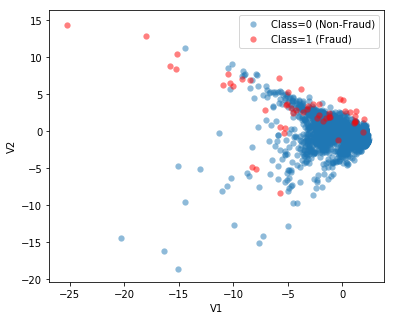

In [30]:
y = df['Class']
X = df.drop(['Class'], axis=1)  

fig, ax = plt.subplots(figsize=(6,5))

ax.set_xlabel('V1'), ax.set_ylabel('V2')
ax.scatter(X.loc[y == 0, 'V1'], X.loc[y == 0, 'V2'], label="Class=0 (Non-Fraud)", alpha=0.5, linewidth=0.15)
ax.scatter(X.loc[y == 1, 'V1'], X.loc[y == 1, 'V2'], label="Class=1 (Fraud)", alpha=0.5, linewidth=0.15, c='r')  
ax.legend()
plt.show()

there is a large inbalance in the data, we need re-weighting or re-sampling

### 1.1 - Model Performance
- accuracy is not a good metric because classes are imbalanced classes
- classification report: precison, recall and f1
  - precision: from the ones you classified as positive, how many were correctly classified
  - recall: from the ones that are positive, how many were correctly classified
- ROC_AUC: "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?"
- confusion matrix 

In [172]:
def get_model_result(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)

    print(f"R2: {r2_score(y_test, predicted):0.3f}")
    print(f"Roc_Auc: {roc_auc_score(y_test, probs[:,1]):0.3f}\n")
    
    print('Classifcation report:\n', classification_report(y_test, predicted))
    #conf_mat = confusion_matrix(y_test, predicted)
    #print('Confusion matrix:\n', conf_mat)
    class_names = np.array(['Non-Fraud', 'Fraud'])
    myML_functions.plot_confusion_matrix(y_test, predicted, classes=class_names)
    plt.show()

<br>

## 2 - Fraud detection with a simple rule
- flag as fraud 4 sigma outliers on the first 10 columns

Mean of V1, V2 and V3 for non-fraud and fraud:


,V1,V2,V3,V4,V5,V6,V7,V8,V9
Class,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728



Confusion matrix, without normalization


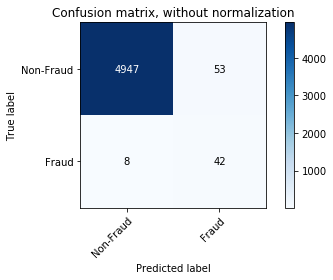

In [173]:
print("Mean of V1, V2 and V3 for non-fraud and fraud:")
mean = np.array(df.loc[df['Class']==0,:].groupby('Class').mean())[0]
std = np.array(df.loc[df['Class']==0,:].groupby('Class').std())[0]
display(df.groupby('Class').mean().iloc[:,:9])
print("")

# Implement a rule for stating which cases are flagged as fraud
df['flag_as_fraud'] = 0
sel = True
for ii in range(0, 10):       
    sel = (df.iloc[:,ii] < (mean[ii] - 2*std[ii])) | (df.iloc[:,ii] > (mean[ii] + 2*std[ii])) & sel    
df.loc[sel,'flag_as_fraud'] = 1

#print(pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))
class_names = np.array(['Non-Fraud', 'Fraud'])
plot_confusion_matrix(df['Class'], df['flag_as_fraud'], classes=class_names)
plt.show()

<br>

## 3 - Detect fraud with supervised learning and re-sampling

### 3.1 - Data Re-sampling with SMOTE
- over-sample fraud class (ROS): duplicates information 
- under-sample non-fraud (RUS): throws away a lot of information
- Synthetic Minority Oversampling Technique (SMOTE) - avoid duplicates using nearest neighbours (only works well if fraud cases are similar enough)

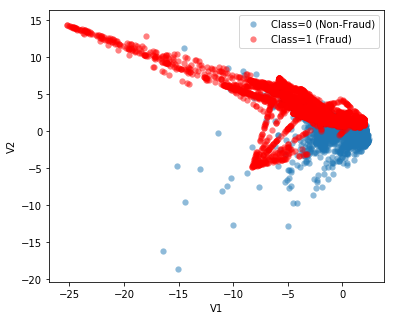

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#method = RandomOverSampler()
#method = SMOTE(kind='borderline1')
method = SMOTE(kind='borderline2')
#method = SMOTE(kind='regular')

#resampling method needs np.array as input
X_resampled, y_resampled = method.fit_sample(np.array(X_train), np.array(y_train))

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel('V1'), ax.set_ylabel('V2')
ax.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], 
           label="Class=0 (Non-Fraud)", alpha=0.5, linewidth=0.15)
ax.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], 
           label="Class=1 (Fraud)", alpha=0.5, linewidth=0.15, c='r')  
ax.legend()
plt.show()

### 3.2 - RandomForestClassifier with SMOTE resampling

R2: 0.832
Roc_Auc: 1.000

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1503
           1       0.86      1.00      0.92        12

   micro avg       1.00      1.00      1.00      1515
   macro avg       0.93      1.00      0.96      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix, without normalization


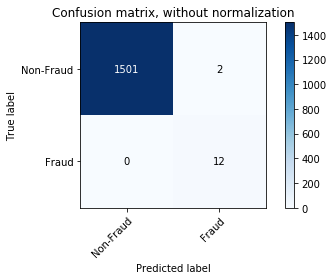

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
method = SMOTE(kind='borderline2')
X_resampled, y_resampled = method.fit_sample(np.array(X_train), np.array(y_train))

#model = LogisticRegression(solver='lbfgs', max_iter=10000)
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
get_model_result(X_resampled, y_resampled, X_test, y_test, model)

### 3.3 - RandomForestClassifier with SMOTE resampling using a pipeline

R2: 0.799
Roc_Auc: 0.999

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.83      1.00      0.91        10

   micro avg       1.00      1.00      1.00      1515
   macro avg       0.92      1.00      0.95      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix, without normalization


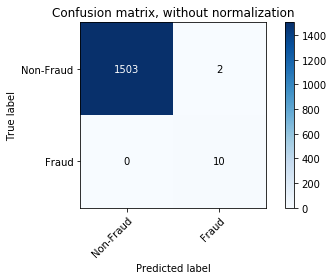

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

resampling = SMOTE(kind='borderline2')
#model = LogisticRegression(solver='lbfgs', max_iter=10000)
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
pipeline = Pipeline([('SMOTE', resampling), ('Random Forest Classifier', model)])

get_model_result(X_train, y_train, X_test, y_test, pipeline)

<br>

## 4 - Detect fraud with supervised learning and adjusted Class_Weight

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

R2: 0.797
Roc_Auc: 0.973

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1495
           1       1.00      0.80      0.89        20

   micro avg       1.00      1.00      1.00      1515
   macro avg       1.00      0.90      0.94      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix, without normalization


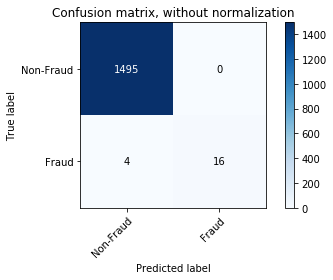

In [177]:
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced_subsample', random_state=5)
get_model_result(X_train, y_train, X_test, y_test, model)

R2: 0.899
Roc_Auc: 0.984

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1495
           1       1.00      0.90      0.95        20

   micro avg       1.00      1.00      1.00      1515
   macro avg       1.00      0.95      0.97      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix, without normalization


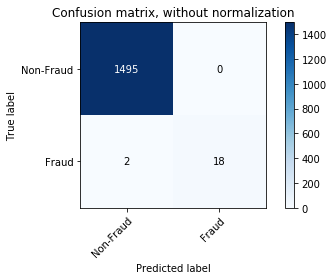

In [178]:
model = RandomForestClassifier(n_estimators=300, bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy', 
                               max_depth=10, min_samples_leaf=10, n_jobs=-1, random_state=5)
get_model_result(X_train, y_train, X_test, y_test, model)

<br>

## 5 - Simple GridSearchCV on RandomForestClassifier

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [180]:
param_grid = {'n_estimators': [1, 30], 
              'max_features': ['auto', 'log2'],  
              'max_depth': [4, 8], 
              'criterion': ['gini', 'entropy']}

model = RandomForestClassifier(random_state=5)

CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall')
CV_model.fit(X_train, y_train)
print(CV_model.best_params_)
print(CV_model.best_estimator_)
print(CV_model.best_score_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)
0.8857142857142857


R2: 0.798
Roc_Auc: 1.000

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       0.93      0.87      0.90        15

   micro avg       1.00      1.00      1.00      1515
   macro avg       0.96      0.93      0.95      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix, without normalization


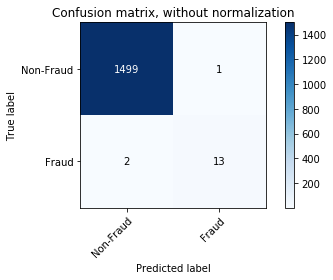

In [181]:
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini', n_estimators=30, max_features='log2',  
                               min_samples_leaf=10, max_depth=8, n_jobs=-1, random_state=5)
get_model_result(X_train, y_train, X_test, y_test, model)

### 5.1 - Cross_val_predict

R2: 0.838
Roc_Auc: 0.986

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       0.96      0.88      0.92        50

   micro avg       1.00      1.00      1.00      5050
   macro avg       0.98      0.94      0.96      5050
weighted avg       1.00      1.00      1.00      5050

Confusion matrix, without normalization


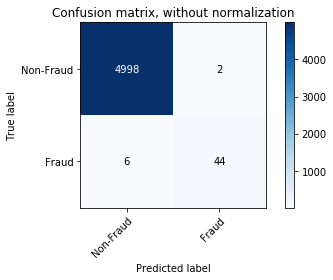

In [183]:
kf = KFold(10, shuffle=True, random_state=1)

predictions = cross_val_predict(model, X, y, cv=kf, )
predictions = pd.Series(predictions)
pred_proba = cross_val_predict(model, X, y, cv=kf,method='predict_proba')

print(f"R2: {r2_score(y, predictions):0.3f}")
print(f"Roc_Auc: {roc_auc_score(y, pred_proba[:,1]):0.3f}\n")
    
print('Classifcation report:\n', classification_report(y, predictions))

class_names = np.array(['Non-Fraud', 'Fraud'])
myML_functions.plot_confusion_matrix(y, predictions, classes=class_names)
plt.show()

<br>

## 6 - Ensemble Models
- bagging/bootstrap ensemble: train model on subsets of the trainning data, then average predictions
- stacking: train on entire trainning data, then vote (can combine algorithms of different types)
- taking a lot of methods into account and average them to obtain robust predictions
  - less prone to overfitting
  - better predictions if combining models with different recall and precision scores
- Votingclassifier: hard (majority vote), soft (combine individual models probs into average probability)

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

R2: 0.840
Roc_Auc: 0.999

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1496
           1       0.90      0.95      0.92        19

   micro avg       1.00      1.00      1.00      1515
   macro avg       0.95      0.97      0.96      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix, without normalization


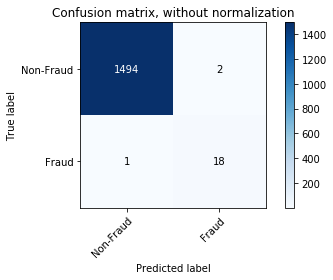

In [185]:
clf1 = LogisticRegression(class_weight={0:1, 1:15}, solver='lbfgs', max_iter=1000, random_state=1)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=100, n_jobs=-1, random_state=5)
clf3 = GaussianNB()
#clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

estimators = [('lr', clf1),('rf', clf2), ('gnb', clf3)]

#ensemble_model = VotingClassifier(estimators=estimators, voting='hard')
ensemble_model = VotingClassifier(estimators=estimators, voting='soft', weights=[1,1,1])

get_model_result(X_train, y_train, X_test, y_test, ensemble_model)

### 6.1 - Cross_val_predict

R2: 0.697
Roc_Auc: 0.990

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       0.80      0.94      0.86        50

   micro avg       1.00      1.00      1.00      5050
   macro avg       0.90      0.97      0.93      5050
weighted avg       1.00      1.00      1.00      5050

Confusion matrix, without normalization


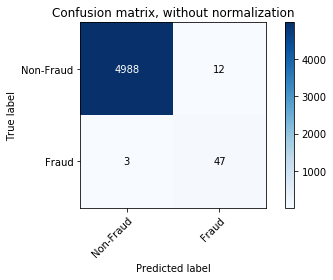

In [186]:
model = ensemble_model
kf = KFold(10, shuffle=True, random_state=1)

predictions = cross_val_predict(model, X, y, cv=kf, )
predictions = pd.Series(predictions)
pred_proba = cross_val_predict(model, X, y, cv=kf,method='predict_proba')

print(f"R2: {r2_score(y, predictions):0.3f}")
print(f"Roc_Auc: {roc_auc_score(y, pred_proba[:,1]):0.3f}\n")
    
print('Classifcation report:\n', classification_report(y, predictions))

class_names = np.array(['Non-Fraud', 'Fraud'])
myML_functions.plot_confusion_matrix(y, predictions, classes=class_names)
plt.show()